In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tqdm import tqdm
import contractions
import re
from tensorflow.keras.layers import Input, Embedding, Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.models import Model

In [2]:
df = pd.read_csv('..\\dataset\\train-balanced-sarcasm.csv')
df.shape

(1010826, 10)

In [3]:
df.head()

,label,comment,author,subreddit,score,ups,downs,date,created_utc,parent_comment
0,0,NC and NH.,Trumpbart,politics,2,-1,-1,2016-10,2016-10-16 23:55:23,"Yeah, I get that argument. At this point, I'd ..."
1,0,You do know west teams play against west teams...,Shbshb906,nba,-4,-1,-1,2016-11,2016-11-01 00:24:10,The blazers and Mavericks (The wests 5 and 6 s...
2,0,"They were underdogs earlier today, but since G...",Creepeth,nfl,3,3,0,2016-09,2016-09-22 21:45:37,They're favored to win.
3,0,"This meme isn't funny none of the ""new york ni...",icebrotha,BlackPeopleTwitter,-8,-1,-1,2016-10,2016-10-18 21:03:47,deadass don't kill my buzz
4,0,I could use one of those tools.,cush2push,MaddenUltimateTeam,6,-1,-1,2016-12,2016-12-30 17:00:13,Yep can confirm I saw the tool they use for th...


In [4]:
#sort by createdd date 
df.sort_values(by='created_utc', inplace=True)
df.reset_index(drop=True, inplace=True)

Here I am sorting the dataset by created_utc, as some topics which are consider non-sarcastic today might be consider sarcastic later

In [5]:
df.head()

,label,comment,author,subreddit,score,ups,downs,date,created_utc,parent_comment
0,0,Rhetorical rheddit,veritaze,Marijuana,4,4,0,2009-01,2009-01-01 23:08:43,Why does the US Government support the use of ...
1,0,I was dreaming that I was a Snuffleupagus!,SleepingSheeple,WTF,3,3,0,2009-01,2009-01-01 23:50:50,And how much taxpayer money went into the Cook...
2,1,Obviously the most well-informed and unbiased ...,Tucci,reddit.com,0,0,0,2009-01,2009-01-02 07:03:22,"FTA: Ephraim Sneh, a former member of the Isra..."
3,1,Yes..wikipedia will teach it to you.,Kelevra,worldnews,7,7,0,2009-01,2009-01-02 07:28:56,Some redditors need to read the History of the...
4,0,Cheese.,McCourt,Art,2,2,0,2009-01,2009-01-02 15:28:00,Abstract beauty


In [6]:
#dropping nan values 
df.dropna(inplace=True)

In [7]:
X_train, X_test = train_test_split(df, test_size=0.2, random_state=42, shuffle=True, stratify=df['label'])
X_train, X_val = train_test_split(X_train, test_size=0.1, random_state=42, shuffle=True, stratify=X_train['label'])
X_train.shape, X_val.shape, X_test.shape

((727756, 10), (80862, 10), (202155, 10))

In [8]:
#coverting string to lowercase 
def string_lower(x):
    for i in ['comment','author','subreddit','parent_comment']:
        x[i] = x[i].str.lower()
    return x

X_train = string_lower(X_train)
X_val = string_lower(X_val)
X_test = string_lower(X_test)

In [9]:
X_train.head()

,label,comment,author,subreddit,score,ups,downs,date,created_utc,parent_comment
34831,0,"it may be taken from ian dury's ""spasticus aut...",vladtheimpala,britishtv,5,5,0,2012-08,2012-08-22 01:41:48,yeah i just tried to forget about the name. al...
198489,0,"raiper running attack, i would restore it to i...",joelxivi,darksouls2,5,5,0,2014-09,2014-09-21 20:15:12,if you could change a single move of a weapon'...
273022,0,"why do you have such an expensive aug skin, bu...",glassofgum,globaloffensive,1,1,0,2015-02,2015-02-09 20:34:32,cheap skins that look nice? i am new to counte...
93500,1,"well that's ok, because we know for a fact tha...",rassimoflom,unitedkingdom,2,2,0,2013-10,2013-10-14 16:19:15,police chiefs will be able to be directly recr...
350017,1,"yeah, more climate change deniers in congress ...",hominid77777,pics,-1,-1,0,2015-06,2015-06-01 19:46:33,more of these guys in the gop would make gover...


In [10]:
#Checking label distribution
X_train['label'].value_counts(), X_val['label'].value_counts(), X_test['label'].value_counts()  

(0    363891
 1    363865
 Name: label, dtype: int64,
 0    40433
 1    40429
 Name: label, dtype: int64,
 0    101081
 1    101074
 Name: label, dtype: int64)

In [11]:
#preprocess textual data
def remove_contractions(x):
    output = []
    for i in x.split(' '):
        output.append(contractions.fix(i))
    output = ' '.join(output)
    #remove newline 
    output = re.sub(r'\n', ' ', output)
    # put spaces before & after punctuations to make words seprate. Like "king?" to "king", "?"
    #code link - https://www.kaggle.com/code/prashantkikani/are-you-being-sarcastic-sarcasm-detection-nlp
    output = re.sub(r"([?!,+=—&%\'\";:¿।।।|\(\){}\[\]//])", r" \1 ", output)
    # Remove more than 2 continues spaces with 1 space.
    output = re.sub('[ ]{2,}', ' ', output).strip()
    return output

def remove_contractions_df(x):
    for i in ['comment','parent_comment']:
        x[i] = x[i].apply(remove_contractions)
    return x

X_train = remove_contractions_df(X_train)
X_val = remove_contractions_df(X_val)
X_test = remove_contractions_df(X_test)

In [12]:
X_train.head()

,label,comment,author,subreddit,score,ups,downs,date,created_utc,parent_comment
34831,0,"it may be taken from ian dury ' s "" spasticus ...",vladtheimpala,britishtv,5,5,0,2012-08,2012-08-22 01:41:48,yeah i just tried to forget about the name. al...
198489,0,"raiper running attack , i would restore it to ...",joelxivi,darksouls2,5,5,0,2014-09,2014-09-21 20:15:12,if you could change a single move of a weapon ...
273022,0,"why do you have such an expensive aug skin , b...",glassofgum,globaloffensive,1,1,0,2015-02,2015-02-09 20:34:32,cheap skins that look nice ? i am new to count...
93500,1,"well that is ok , because we know for a fact t...",rassimoflom,unitedkingdom,2,2,0,2013-10,2013-10-14 16:19:15,police chiefs will be able to be directly recr...
350017,1,"yeah , more climate change deniers in congress...",hominid77777,pics,-1,-1,0,2015-06,2015-06-01 19:46:33,more of these guys in the gop would make gover...


In [13]:
class CFG:
    VOCAB_SIZE = 50000
    MAX_LEN = 40
    EMBEDDING_DIM = 300
    BATCH_SIZE = 1024
    EPOCHS = 25
    LOSS = 'binary_crossentropy'
    OPTIMIZER = 'adam'


In [14]:
#Tokenizing the data
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=CFG.VOCAB_SIZE, oov_token='<unk>')
tokenizer.fit_on_texts(X_train['comment'])

train_data = tokenizer.texts_to_sequences(X_train['comment'])
train_data = tf.keras.preprocessing.sequence.pad_sequences(train_data, maxlen=CFG.MAX_LEN)

val_data = tokenizer.texts_to_sequences(X_val['comment'])
val_data = tf.keras.preprocessing.sequence.pad_sequences(val_data, maxlen=CFG.MAX_LEN)

test_data = tokenizer.texts_to_sequences(X_test['comment'])
test_data = tf.keras.preprocessing.sequence.pad_sequences(test_data, maxlen=CFG.MAX_LEN)

In [15]:
word_index = tokenizer.word_index

In [16]:
embeddings_index = {}
with open('..\\pretrained_model\\glove.840B.300d.txt', encoding='utf-8') as f:
    for line in tqdm(f):
        values = line.split(' ')
        word = values[0]
        coords = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coords
print('Found %s word vectors.' % len(embeddings_index))

2196017it [02:20, 15659.22it/s]

Found 2196016 word vectors.


In [18]:
embedding_matrix = np.zeros((len(word_index) + 1, CFG.EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [21]:
input_layer = Input(shape=(CFG.MAX_LEN,))
embedding_layer = Embedding(input_dim=len(word_index)+1,
                            output_dim=CFG.EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=CFG.MAX_LEN,
                            trainable=False)(input_layer)
lstm_layer = LSTM(100,name='LSTM')(embedding_layer)
dropout_layer = Dropout(0.2)(lstm_layer)
dense_layer_1 = Dense(units=256, activation='sigmoid')(dropout_layer)
dense_layer_2 = Dense(units=128, activation='sigmoid')(dropout_layer)
output_layer = Dense(units=1, activation='sigmoid')(dense_layer_2)

model = Model(inputs=input_layer, outputs=output_layer)
model.compile(loss=CFG.LOSS, optimizer=CFG.OPTIMIZER, metrics=['accuracy'])

In [22]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 40)]              0         
                                                                 
 embedding_2 (Embedding)     (None, 40, 300)           41777700  
                                                                 
 LSTM (LSTM)                 (None, 100)               160400    
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               12928     
                                                                 
 dense_2 (Dense)             (None, 1)                 129       
                                                                 
Total params: 41,951,157
Trainable params: 173,457
Non-traina

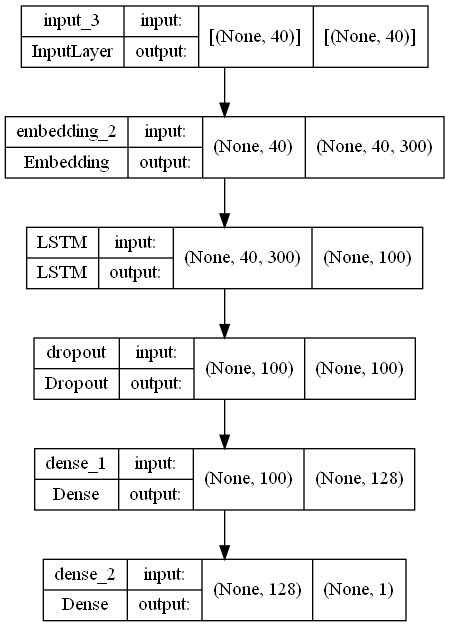

In [23]:
#plot the model
tf.keras.utils.plot_model(model, to_file='model.png', show_shapes=True)

In [24]:
try:
    history = model.fit(train_data, X_train['label'], batch_size=CFG.BATCH_SIZE, epochs=CFG.EPOCHS, validation_data=(val_data, X_val['label']))
except KeyboardInterrupt:
    print('\nTraining stopped by user.')

Epoch 1/25
711/711 [==============================] - 37s 47ms/step - loss: 0.5984 - accuracy: 0.6703 - val_loss: 0.5590 - val_accuracy: 0.7097
Epoch 2/25
711/711 [==============================] - 33s 47ms/step - loss: 0.5512 - accuracy: 0.7154 - val_loss: 0.5416 - val_accuracy: 0.7224
Epoch 3/25
711/711 [==============================] - 33s 47ms/step - loss: 0.5367 - accuracy: 0.7263 - val_loss: 0.5347 - val_accuracy: 0.7288
Epoch 4/25
711/711 [==============================] - 33s 47ms/step - loss: 0.5274 - accuracy: 0.7337 - val_loss: 0.5330 - val_accuracy: 0.7314
Epoch 5/25
711/711 [==============================] - 33s 47ms/step - loss: 0.5192 - accuracy: 0.7395 - val_loss: 0.5269 - val_accuracy: 0.7336
Epoch 6/25
711/711 [==============================] - 33s 47ms/step - loss: 0.5126 - accuracy: 0.7442 - val_loss: 0.5271 - val_accuracy: 0.7346
Epoch 7/25
711/711 [==============================] - 34s 47ms/step - loss: 0.5067 - accuracy: 0.7485 - val_loss: 0.5245 - val_accuracy:

In [25]:
model.evaluate(test_data, X_test['label'])

6318/6318 [==============================] - 20s 3ms/step - loss: 0.5296 - accuracy: 0.7356


[0.5296308994293213, 0.7355890274047852]